# Texture Synthesis Preparation: Classification with SVM

<h4>Application and analysis of texture classification using SVM against dataset of differing textures, in order to prepare for Neural Network based Texture Synthesis, Procedural Texture generation, and applications of Computer Vision object recognition.</h4>

## Problem: Texture Synthesis Requires Pre-Classification

<h2>What is Texture Synthesis?</h2>
<h4><b><i>Texture Synthesis::</i></b>
<br>
Texture Synthesis is the process of generating novel textures from samples of existing textures and imagery, while retaining the visual elements of the original. 
Texture Synthesis can be used to in 2D and 3D image generation applications, such as::</h4>

<h5>Extend existing images and textures mathematically such as procedural textures to solve 2D image tiling</h5>
<img src ="img/TextureTiling.png" alt="TextureTiling.png" width="500" height="400">
<br>
<i>Blender Guru, "Blender Texturing for Beginners - Tutorial"<i>

<h5>Move materials from one type of material to another in existing images in Texture Transfer</h5>
<img src ="img/TextureTransfer.png" alt="TextureTransfer.png" width="500" height="400">
<br>
<i>University of Illinois, "Textureshop: Texture Synthesis as as Photograph Editing Tool"<i>

<h5>Shift portions or entirety of textures from one art style to another via Quilting or Image Analogies and Artistic Filters.</h5>
<img src ="img/TextureAImageAnalogy.png" alt="TextureAnalogy.png" width="500" height="400">
<br>
<i>University of Washington, "Texture Synthesis"<i>

<h3><b>And many more applications!</b></h3>
<h4>Textures generated via synthesis methods through these approaches are known as Synthetic Textures, and are a precursory method to creating procedural textures in large scale 3D applications.</h4> 

<h2><b><i>Summary of Goal:: </b></i>Explore the preparation of training classification models on existing textures, in preparation for later Neural Network Synthetic Texture Genesis.</h2>

## Definition of the Texture Collection Dataset

<h4><b><i>Origin of the Textures Dataset::</i></b>
<br>
This data all came from hand, from me walking about my apartment complex taking photos like a total weirdo - we'll call this scientific process <b>Photogrammetric Loitering</b></h4>
<li>Size of the dataset can be represented as varying classes of textures depending on how many models and which kinds are used</li>
<li>Dataset comprises 5 directories with 8 images for each type, and one 'other' folder for later testing - it is a mixture of other texture types</li>
<li>Data cleaning in this project began in this controlled case by my own picking and deleting unwanted or unused textures by hand prior to training</li>

<h4><b><i>Pull the Dataset from .Zip Folder 'Textures'::</i></b></h4>


In [2]:
# Importing the packages
import os
import shutil
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.feature import local_binary_pattern
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

# Function for extracting our zip folders - saving temp directory 'extract_path' to delete later
def load_textures_from_zip(zip_path):
    images = []
    extract_path = zip_path.replace('.zip', '')  # Create a folder path for extraction
    with zipfile.ZipFile(zip_path, 'r') as archive:
        archive.extractall(extract_path)
    for root, _, files in os.walk(extract_path):
        for file_name in files:
            if file_name.endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file_name)
                img = Image.open(file_path)
                images.append(img)
    return images, extract_path

# Load textures for each category and save their temp directory
brick_textures, brick_extract_path = load_textures_from_zip("img/textures/brick.zip")
grass_textures, grass_extract_path = load_textures_from_zip("img/textures/grasses.zip")
leaves_textures, leaves_extract_path = load_textures_from_zip("img/textures/leaves.zip")
road_textures, road_extract_path = load_textures_from_zip("img/textures/road.zip")
sidewalk_textures, sidewalk_extract_path = load_textures_from_zip("img/textures/sidewalk.zip")

## Preparing the Data For Processing

<h4><b><i>Perform Data Preprocessing - Grayscale Conversion::</i></b></li>
<br>
In order to classify these textures, they will be first converted into grayscale counterparts.</h4>

In [3]:
# Function to convert textures to grayscale in preparation for Local Binary extraction
def convert_to_grayscale(textures):
    grayscale_textures = [np.array(texture.convert('L')) for texture in textures]
    return np.array(grayscale_textures)

# Convert to grayscale
brick_textures = convert_to_grayscale(brick_textures)
grass_textures = convert_to_grayscale(grass_textures)
leaves_textures = convert_to_grayscale(leaves_textures)
road_textures = convert_to_grayscale(road_textures)
sidewalk_textures = convert_to_grayscale(sidewalk_textures)

<h4><b><i>Perform Data Preprocessing - Local Binary Extraction::</i></b></li>
<br>
To operate on the now grayscale textures, they will be stored as Local Binary Data in order to compare with the model.</h4>

In [4]:
# Function to extract features from grayscale textures
def extract_lbp_features(textures, radius=3, n_points=8*3):
    lbp_features = [local_binary_pattern(texture, P=n_points, R=radius, method='uniform').flatten() for texture in textures]
    return np.array(lbp_features)

# Extract our features
brick_features = extract_lbp_features(brick_textures)
grass_features = extract_lbp_features(grass_textures)
leaves_features = extract_lbp_features(leaves_textures)
road_features = extract_lbp_features(road_textures)
sidewalk_features = extract_lbp_features(sidewalk_textures)

<h4><b><i>Perform Data Preprocessing - Cleanup::</i></b></li>
<br>
Delete the temporarily created directories from .zip extraction in earlier stage.</h4>

In [5]:
# Remove the extracted folders now that we have our image data
shutil.rmtree(brick_extract_path)
shutil.rmtree(grass_extract_path)
shutil.rmtree(leaves_extract_path)
shutil.rmtree(road_extract_path)
shutil.rmtree(sidewalk_extract_path)

## Data Exploration

<h4><b><i>Perform Data Exploration and Analysis::</i></b></li>
<br>
Build our features and labels, visualizing them prior to model training.</h4>

Shape of 'X' before Pre-process: (42, 12192768)
Shape of 'y' before preprocess: (42,)

Class distribution in 'y' before preprocess:
{np.int64(0): np.int64(10), np.int64(1): np.int64(8), np.int64(2): np.int64(8), np.int64(3): np.int64(8), np.int64(4): np.int64(8)}


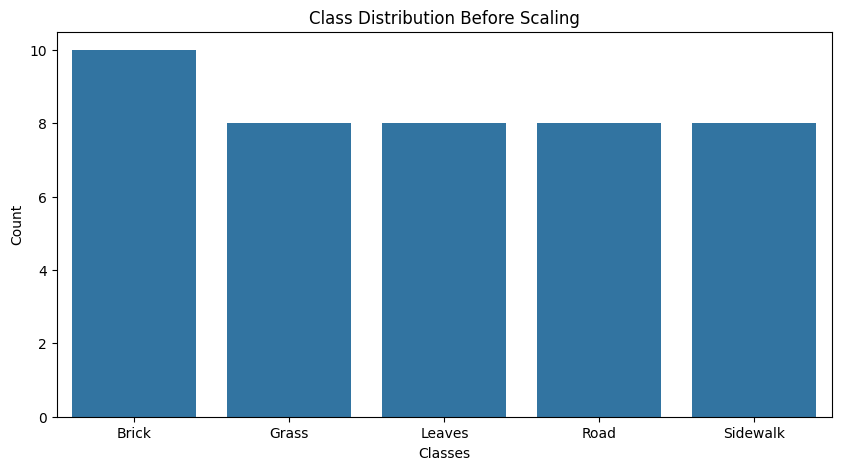

In [6]:
# 0 for brick, 1 for grass, 2 for leaves, 3 for road, 4 for sidewalk
X = np.vstack([brick_features, grass_features, leaves_features, road_features, sidewalk_features])
y = np.array([1]*len(grass_features) + [0]*len(brick_features) + [2]*len(leaves_features) + [3]*len(road_features) + [4]*len(sidewalk_features))

# This data is used for grass vs. grass with leaves
X_grasses = np.vstack([grass_features, leaves_features])
y_grasses = np.array([1]*len(leaves_features) + [0]*len(grass_features))

# This data is used for sidewalk vs. road, the most likely to make errors
X_stones = np.vstack([road_features, sidewalk_features])
y_stones = np.array([1]*len(sidewalk_features) + [0]*len(road_features))

# View distribution of the full data as part of data exploration prior to any scaling
print("Shape of 'X' before Pre-process:", X.shape)
print("Shape of 'y' before preprocess:", y.shape)
print("\nClass distribution in 'y' before preprocess:")
unique, counts = np.unique(y, return_counts=True)
class_dist = dict(zip(unique, counts))
print(class_dist)

# Plotting
plt.figure(figsize=(10, 5))
sns.countplot(x=y)
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['Brick', 'Grass', 'Leaves', 'Road', 'Sidewalk'])
plt.title('Class Distribution Before Scaling')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

<h4><b><i>Perform Data Scaling via Standard Scaler::</i></b></li>
<br>
Utilize the standard scaler as there are different colors and intensities across images that will need to be scaled.</h4>

In [7]:
# Prepare our scaler 
scaler = StandardScaler()

# Scale our 'X's for various models to train
X_scaled = scaler.fit_transform(X)
X_grasses_scaled = scaler.fit_transform(X_grasses)
X_stones_scaled = scaler.fit_transform(X_stones)

# View data after scaling
print("Shape of 'X' after scaling:", X_scaled.shape)
print("Mean of 'X' after scaling:", np.mean(X_scaled))
print("Standard deviation of 'X'", np.std(X_scaled))

Shape of 'X' after scaling: (42, 12192768)
Mean of 'X' after scaling: -3.000133443193257e-16
Standard deviation of 'X' 0.9999999999999978


## Model Building

<h4><b><i>Spit Train and Test Sets::</i></b></li>
<br>
As we are classifying these textures, we will select the SVM model. The target models to analyze and research will be:</h4>
<li>Full Texture Set</li>
<li>Grass vs. Grass with Leaves</li>
<li>Road vs. Sidewalk</li>


In [8]:
# Split into multiple batches of training data for the varied models
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Xg for grasses
Xg_train, Xg_test, yg_train, yg_test = train_test_split(X_grasses_scaled, y_grasses, test_size=0.3, random_state=42)

# Xst for stones
Xst_train, Xst_test, yst_train, yst_test = train_test_split(X_stones_scaled, y_stones, test_size=0.3, random_state=42)

<h4><b><i>Fit Models and Store Predictions::</i></b></li>
<br>
Train models on the SKLearn's SVC model in order to train and predict classification on our various texture datas. We have opted for 'linear' kernel as it is recommended from research done on our binary image data. RBF will also be compared.</h4>

In [9]:
# Train first model type
texture_classifier = SVC(kernel='linear')
texture_classifier.fit(X_train, y_train)

# Prediction Storing
y_pred = texture_classifier.predict(X_test)

# Accuracy Storing
accuracy_scores = {}
accuracy = accuracy_score(y_test, y_pred)
accuracy_scores['Main Model [Linear]'] = accuracy


# Train the RBF model type on same data
texture_rbf = SVC(kernel='rbf')
texture_rbf.fit(X_train, y_train)
y_pred_rbf = texture_rbf.predict(X_test)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
accuracy_scores['Main Model [RBF]'] = accuracy_rbf

# Train and predict on the grass data
texture_classifier.fit(Xg_train, yg_train)
y_pred_grass = texture_classifier.predict(Xg_test)
accuracy_grass = accuracy_score(yg_test, y_pred_grass)
accuracy_scores['Grasses [Linear]'] = accuracy_grass

texture_rbf.fit(Xg_train, yg_train)
y_pred_grass_rbf = texture_rbf.predict(Xg_test)
accuracy_grass_rbf = accuracy_score(yg_test, y_pred_grass_rbf)
accuracy_scores['Grasses [RBF]'] = accuracy_grass_rbf

# Train and predict on the stone data
texture_classifier.fit(Xst_train, yst_train)
y_pred_stone = texture_classifier.predict(Xst_test)
accuracy_stone = accuracy_score(yst_test, y_pred_stone)
accuracy_scores['Stones [Linear]'] = accuracy_stone

texture_rbf.fit(Xst_train, yst_train)
y_pred_stone_rbf = texture_rbf.predict(Xst_test)
accuracy_stone_rbf = accuracy_score(yst_test, y_pred_stone_rbf)
accuracy_scores['Stones [RBF]'] = accuracy_stone_rbf

Overall classification accuracy: 0.38461538461538464


<h3>Visualizing Some of the Predicitons from the Models</h3>

Checking predictions on brick


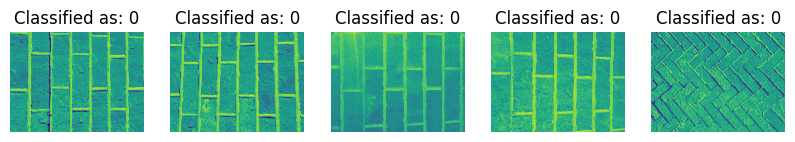

No images classified as 1
No images classified as 2
No images classified as 3
Checking predictions on grasses


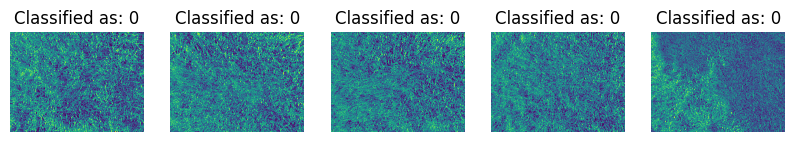

No images classified as 1
No images classified as 2
No images classified as 3
Checking predictions on leaves


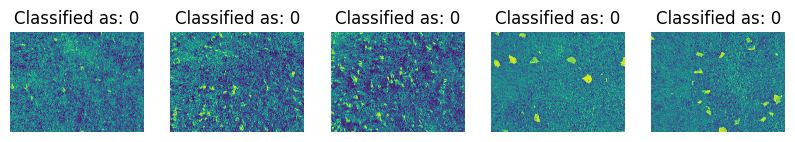

No images classified as 1
No images classified as 2
No images classified as 3
Checking predictions on road


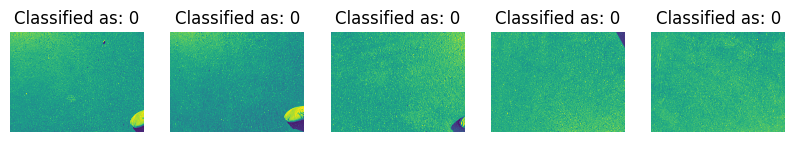

No images classified as 1
No images classified as 2
No images classified as 3
Checking predictions on sidewalks


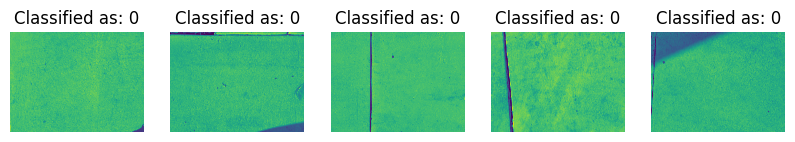

No images classified as 1
No images classified as 2
No images classified as 3


In [30]:
# Displaying which were classified
def display_classified_images(images, y_pred, class_label, num_images=5):
    classified_indices = [i for i, label in enumerate(y_pred) if label == class_label]

    # Limit to the number of images specified (e.g., show only 5 images)
    classified_indices = classified_indices[:num_images]

    # Plot the images
    if len(classified_indices) > 0:
        plt.figure(figsize=(10, 5))
        for idx, img_index in enumerate(classified_indices):
            plt.subplot(1, len(classified_indices), idx + 1)
            plt.imshow(images[img_index])  # Show the original image (before grayscale conversion)
            plt.title(f"Classified as: {class_label}")
            plt.axis('off')  # Hide axis
        plt.show()
    else:
        print(f"No images classified as {class_label}")

print("Checking predictions on brick")
display_classified_images(brick_textures, y_pred, class_label=0)
display_classified_images(brick_textures, y_pred, class_label=1)
display_classified_images(brick_textures, y_pred, class_label=2)
display_classified_images(brick_textures, y_pred, class_label=3)

print("Checking predictions on grasses")
display_classified_images(grass_textures, y_pred, class_label=0)
display_classified_images(grass_textures, y_pred, class_label=1)
display_classified_images(grass_textures, y_pred, class_label=2)
display_classified_images(grass_textures, y_pred, class_label=3)

print("Checking predictions on leaves")
display_classified_images(leaves_textures, y_pred, class_label=0)
display_classified_images(leaves_textures, y_pred, class_label=1)
display_classified_images(leaves_textures, y_pred, class_label=2)
display_classified_images(leaves_textures, y_pred, class_label=3)

print("Checking predictions on road")
display_classified_images(road_textures, y_pred, class_label=0)
display_classified_images(road_textures, y_pred, class_label=1)
display_classified_images(road_textures, y_pred, class_label=2)
display_classified_images(road_textures, y_pred, class_label=3)

print("Checking predictions on sidewalks")
display_classified_images(sidewalk_textures, y_pred, class_label=0)
display_classified_images(sidewalk_textures, y_pred, class_label=1)
display_classified_images(sidewalk_textures, y_pred, class_label=2)
display_classified_images(sidewalk_textures, y_pred, class_label=3)



## Evaluation

<h4><b><i>Generate and Display Confusion Matrix, Display Predictions::</i></b></li>
<br>
Utilizing a heatmap and confusion matrix first, we display the performance of the main target model. We will then evaluate which images were selected for each class.</h4>


Accuracy Scores of All Models::
Main Model [Linear]:: 0.38461538461538464
Main Model [RBF]:: 0.07692307692307693
Grasses [Linear]:: 0.4
Grasses [RBF]:: 0.4
Stones [Linear]:: 0.4
Stones [RBF]:: 0.4


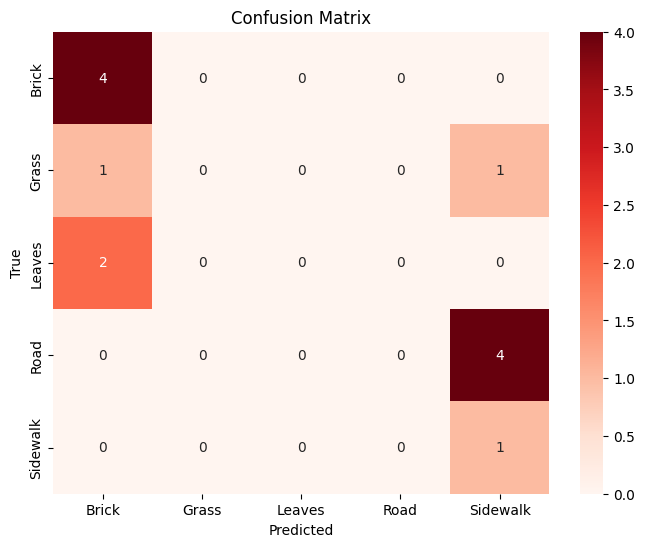

In [11]:
# Print out all other accuracy scores in the dictionary
print("\nAccuracy Scores of All Models::")
for key, value in accuracy_scores.items():
    print(f"{key}:: {value}")

# Generate main confusion matrix for all texture model
texture_cm = confusion_matrix(y_test, y_pred)
class_names = ['Brick', 'Grass', 'Leaves', 'Road', 'Sidewalk']

plt.figure(figsize=(8, 6))
sns.heatmap(texture_cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Conclusions and Next Steps

<h4><b><i>Observations::</i></b>
<br>
<br>
<i>Data Exploration::</i>
<li>The class distribution step of the data exploration correctly displays image count from our directories.</li>
<li>The standard deviation after scaling is fairly close to 0 in the main dataset.</li>
<br>
<i>Model Building::</i>
<li>The classification accuracy of the main model set was very low! This could come from either an error in that .Zip files unzipped into nested directories while preparing data, or, it could be that the Stone and Sidewalk were very difficult to classify - *I am writing this as I study and research, so the accuracy scores of other models are yet to be seen.</li>
<br>
<i>Evaluations::</i>
<li>The accuracy scores for each of the models was very low - .4!.</li>
<li>Main model lagged just slightly behind the other models accuracy levels</li>
<li>I am rather <b><i>Shocked</i></b> that the grass vs leaves struggled so badly! I believe that perhaps the grayscale nature of the project became an issue, as these textures with color values would have been much more accurate in my mind</li>
<li>As expected, from the accuracy and confusion matrix, the model struggled to identify the differences in sidewalk and road. These images are very very similar on disk, and it may come down to the intensity value that is stored.</li>
<li>Lastly, looking over the actual predictions from the 'y_pred' on the main model, it does seem to have gotten several things correctly done! I may have done something in my setup incorrectly someplace, and will continue to tweak the data and the model, wondering if perhaps I've misplaced the index of a label some place! For example they all seem to classify their correct labels as under 'classification 0'</li>

</h4>

<h4><b><i>Extensions to the Project::</i></b>
<br>
I will continue to research into classification of these textures with similar and other means. Were these images preprocessed incorrectly? Were light intensity values an issue such that many binary datas were too similar to predict from? Are there any methods without using Deep Learning that can run similar tests utilizing color?

There are many applications for Texture Synthesis available now that we have successfully classified, to an extent, the textures that we might use. Maybe we want to go to procedural generation immediately and work on generating the borders around existing image textures? Maybe we want to create a specific art style for in-house graphics trained exclusively on synthetic textures and real work from local artists? Many of the next steps would need to take this classifier as a first step in order to train further Deep Learning models - something I will anxiously look forward to in the coming months.</h4>
<h4><b><i>A Small List of Potential Applications</i></b></h4>
<li>Virtual Textures and Virtual Geometry (Unreal Engine Nanite)</li>
<li>Synthetic Normal and Parallax Maps</li>
<li><a href="https://ieeexplore.ieee.org/document/8942651">Procedural Texture Generation (Tiny Glade)</a></li>
<li><a href="https://www.a23d.co/texture/syntheticmaterial-0400882">Synthetic Materials</a></li>


<h4><i>Sources::<i></h4>
<li><a href="https://courses.cs.washington.edu/courses/cse455/08wi/lectures/texture.pdf">University of Washington Texture Lecture</a></li>
<li><a href="https://graphics.cs.yale.edu/sites/default/files/edge-based_procedural_textures.pdf">Edge-Based Procedural Textures</a></li>
<li><a href="https://github.com/anopara">Anastasia Opara GitHub Research Repo</a></li>
<li><a href="https://medium.com/@allenaltiner/computer-generated-procedural-3d-and-multi-example-texture-based-synthesis-by-the-super-talented-4d1cfe34b05c">Texture Synthesis from Example</a></li>
<li><a href="https://pixel.ecn.purdue.edu:8443/projects/ITRweb/content/publication_related/uiuc/textureshop.pdf">University of Illinois - Textureshop</a></li>
<li><a href="https://apmonitor.com/pds/index.php/Main/TextureClassification">Machine Learning for Engineers - Prof. John D. Hedengren, BYU</a></li>